In [14]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
Bacterialblight = ['/kaggle/input/rice-leaf-dataset-from-mendeley-data/Rice Leaf Disease Images/Bacterialblight']
Blast = ['/kaggle/input/rice-leaf-dataset-from-mendeley-data/Rice Leaf Disease Images/Blast']
Brownspot = ['/kaggle/input/rice-leaf-dataset-from-mendeley-data/Rice Leaf Disease Images/Brownspot']
Tungro = ['/kaggle/input/rice-leaf-dataset-from-mendeley-data/Rice Leaf Disease Images/Tungro']
file_p = []
labels = []
dict_lists = [Bacterialblight, Blast,Brownspot,Tungro]
class_labels = ['Bacterialblight', 'Blast','Brownspot','Tungro']

for i, dir_list in enumerate(dict_lists):
     for j in dir_list:
            list_f = os.listdir(j)
            for name in list_f:
                fpath = os.path.join(j, name)
                file_p.append(fpath)
                labels.append(class_labels[i])


failpath = pd.Series(file_p, name="filepaths")
Labelss = pd.Series(labels, name="labels")
data = pd.concat([failpath, Labelss], axis=1)
train = pd.DataFrame(data)
train_df, test_df = train_test_split(train, test_size=0.2, random_state=42,stratify=train.labels)
train_df, val_df = train_test_split(train, test_size=0.15, random_state=42,stratify=train.labels)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)


(5042, 2)
(890, 2)
(1187, 2)


In [15]:
def enhance_image(image):
    image = cv2.addWeighted(image, 1.5, image, -0.5, 0)

    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    image = cv2.filter2D(image, -1, kernel)

    hue = image[:, :, 0]
    saturation = image[:, :, 1]
    value = image[:, :, 2]
    value = np.clip(value * 1.25, 0, 255)

    image[:, :, 2] = value

    return image

In [16]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda image: enhance_image(image))
train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(256,256),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=32,
                                      shuffle=False            
                                     )
val = image_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )
test = image_gen.flow_from_dataframe(dataframe= test_df,x_col="filepaths", y_col="labels",
                                    target_size=(256,256),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 5042 validated image filenames belonging to 4 classes.
Found 890 validated image filenames belonging to 4 classes.
Found 1187 validated image filenames belonging to 4 classes.


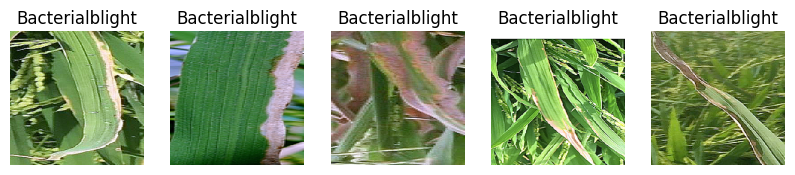

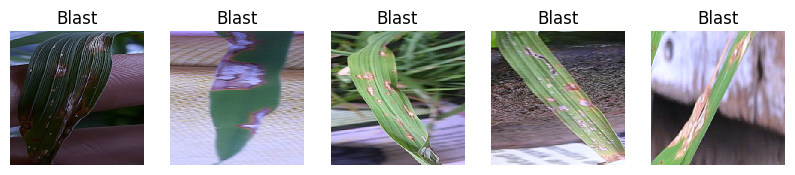

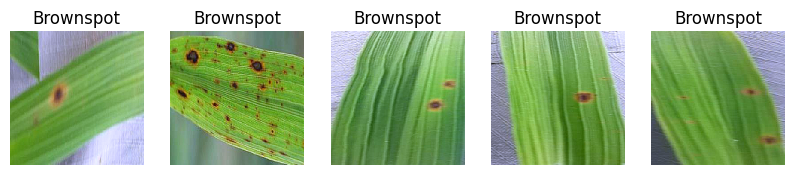

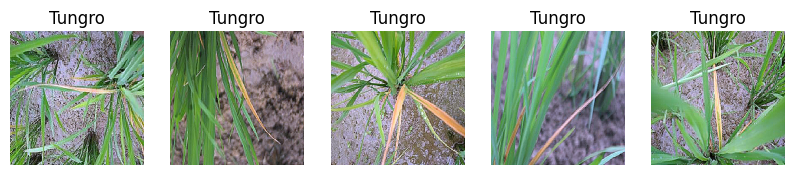

In [17]:
import matplotlib.pyplot as plt
import cv2

# Define the number of images to plot from each class
num_images_per_class = 5

# Get class indices
class_indices = val.class_indices

# Inverse mapping of class indices to class labels
class_labels = {v: k for k, v in class_indices.items()}

# Plot images from each class
for class_index, class_label in class_labels.items():
    # Find the first num_images_per_class images belonging to the current class
    class_images = [image for image, label in zip(val[0][0], val[0][1]) if label[class_index] == 1][:num_images_per_class]
    
    # Plot the images
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(class_images):
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.show()


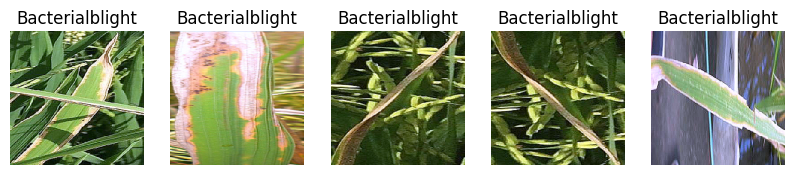

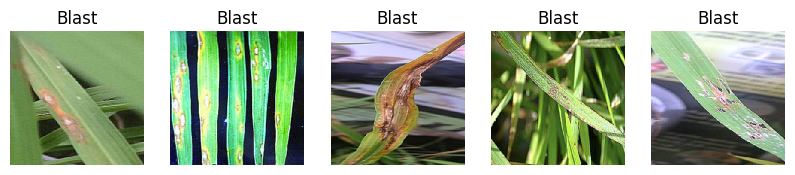

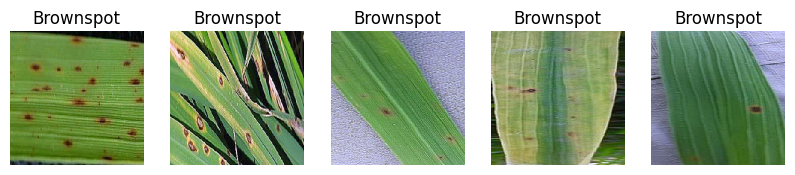

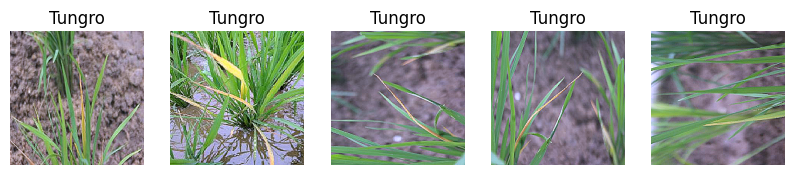

In [18]:
import matplotlib.pyplot as plt

# Define the number of images to plot from each class
num_images_per_class = 5

# Get class indices
class_indices = train.class_indices

# Inverse mapping of class indices to class labels
class_labels = {v: k for k, v in class_indices.items()}

# Plot images from each class
for class_index, class_label in class_labels.items():
    # Find the first num_images_per_class images belonging to the current class
    class_images = [image for image, label in zip(train[0][0], train[0][1]) if label[class_index] == 1][:num_images_per_class]
    
    # Plot the images
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(class_images):
        plt.subplot(1, num_images_per_class, i + 1)
        plt.imshow(image)
        plt.title(class_label)
        plt.axis('off')
    plt.show()


In [27]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras import layers, models

input_shape = (256, 256, 3)

base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=input_shape, pooling='max')
x = base_model.output
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x) 
output = layers.Dense(4, activation='softmax')(x)
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)

model = models.Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [28]:
import matplotlib.pyplot as plt
history1 = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 239s 768ms/step - accuracy: 0.4473 - loss: 2.5742 - val_accuracy: 0.2775 - val_loss: 1.9605
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 36s 223ms/step - accuracy: 0.7825 - loss: 0.6104 - val_accuracy: 0.2472 - val_loss: 2.1230
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 35s 220ms/step - accuracy: 0.8650 - loss: 0.3596 - val_accuracy: 0.3112 - val_loss: 1.9870
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - accuracy: 0.9217 - loss: 0.2154 - val_accuracy: 0.4753 - val_loss: 1.3446
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 35s 219ms/step - accuracy: 0.9458 - loss: 0.1510 - val_accuracy: 0.8955 - val_loss: 0.2830
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 35s 220ms/step - accuracy: 0.9624 - loss: 0.1158 - val_accuracy: 0.9910 - val_loss: 0.0299
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 35s 219ms/step - accuracy: 0.9784 - loss: 0.0701 - val_accuracy: 0.9978 - val_loss: 0.0110
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 35s 219ms/step - accuracy: 0.9788 - loss: 

In [29]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)


38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.9983 - loss: 0.0046
Test Accuracy: 0.9974726438522339


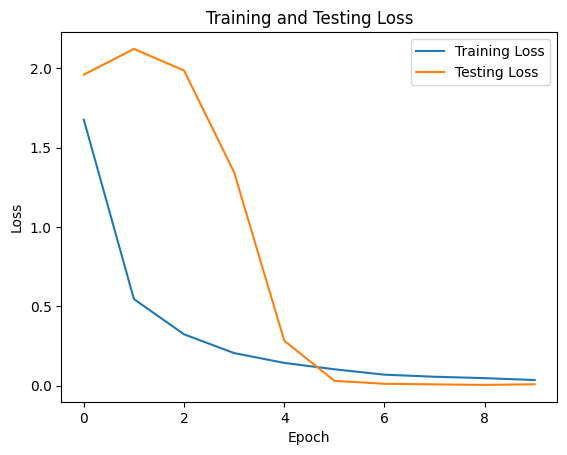

In [30]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()


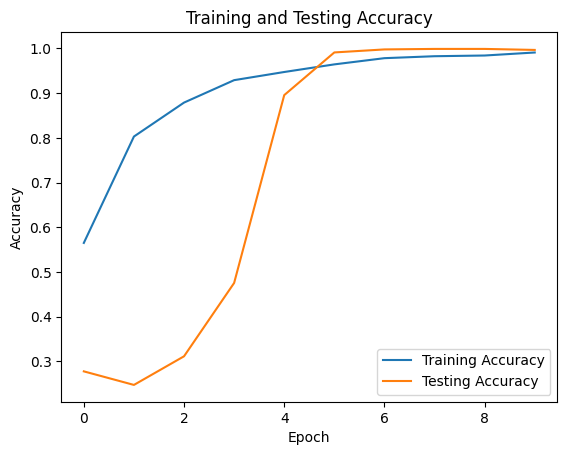

In [31]:
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = model.predict(test)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = test.classes

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 264ms/step
Confusion Matrix:
[[316   1   0   0]
 [  0 288   0   0]
 [  0   2 318   0]
 [  0   0   0 262]]


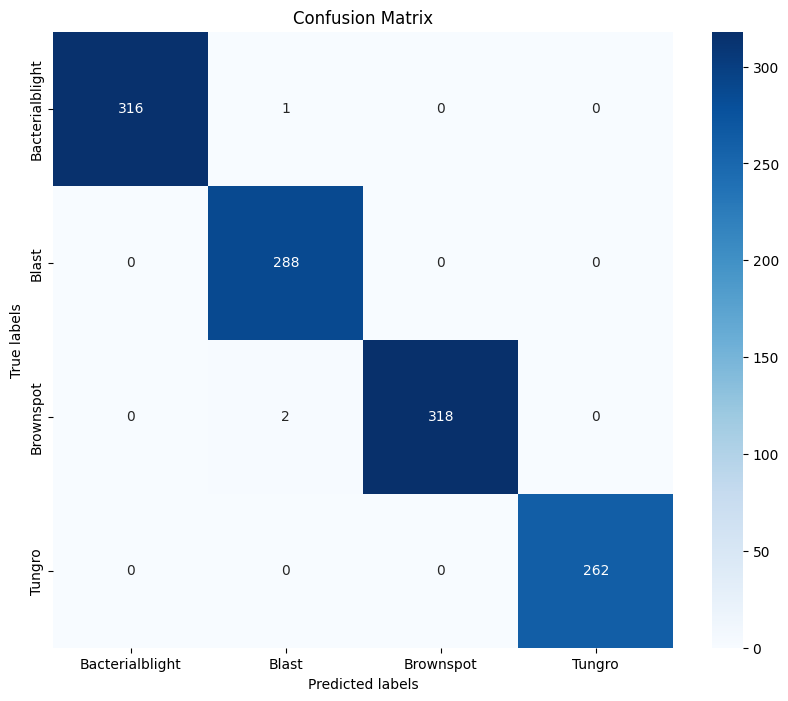

In [33]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test.class_indices.keys(),
            yticklabels=test.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [34]:
# Save the model
model.save("efficientnet_model.h5")
